In [33]:
import pandas as pd
import numpy as np
import statistics
import warnings
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [34]:
with open('dtype_dict.json', 'r') as file:
    dtype_dict = json.load(file)

parse_dates = [key for key, value in dtype_dict.items() if value =='datetime64[ns]']
other_dtypes = {key: value for key,value in dtype_dict.items() if value != 'datetime64[ns]'}

for key in other_dtypes:
    if other_dtypes[key] == 'category':
        other_dtypes[key] = 'category'
    else:
        other_dtypes[key] = pd.api.types.pandas_dtype(other_dtypes[key])

df = pd.read_csv("final_data.csv", dtype=other_dtypes, parse_dates=parse_dates)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


df["Starting_price"] = df["Starting_price"]/1000000
df["Price_Change"] = df["Price_Change"]/1000000
df["Final_Price"] = df["Final_Price"]/1000000

df = df.dropna(subset=['Starting_price'])

Now we shall start off by analyze the data and understand more from it before we starting with the modelling phase. 

In [35]:
df.shape

(2281, 20)

We have 2281 rows and 20 attributes. The dataset is not that big as the "Hemnet" website only allowed for scraping of data upto a certian number of pages resulting in this small dataset. We have 20 attributes in which one of the variable that we would like to predict. 

We shall now explain all the attributes and its data type: 

- House_Name: A unique name of the house. String type
- Location: Location of the house. Categorical type
- Municipality: The municipality within which the house is located. Categorical type
- House_type: The type of house can be of 6 types i.e Lägenhet, Villa, Fritidshus, Parhus, Kedjehus and Tomot. They are named in Swedish and are of categorial type. 
- Release_form: It is a type of document that grants the transfer of rights to a piece of property. They are 5 types i.e Bostadsrätt, Äganderätt, Annat, Tomträtt and Andelibostadsförening. They are named in Swedish and are of categorial type. 
- Living_area: The living area of the house in square meters. Numerical type
- Plot_area: The plot area of the property in square meters (if applicable). Numerical type
- Other_area: The area of other spaces in the house, such as garages or storage rooms, in square meters (if applicable). Numerical type
- Rooms: The number of rooms in the house (if applicable) . Numerical type
- Balcony: Indicates if the house has a balcony (Yes/No) (if applicable) . Categorical type
- Floor: The floor on which the house is located (if applicable). Numerical type 
- Total_no_Floors: The total number of floors in the building. Numerical type
- Lift: Indicates if the building has a lift (Yes/No). Categorical type
- Built_on: The year the house was built. Numerical type
- Charge: The monthly charge for the house, such as maintenance or service fees, in the local currency. Numerical type
- Operating_cost: The yearly operating cost of the house, in the local currency. Numerical type
- Sold_date: The date when the house was sold. Date type
- Starting_price: The initial asking price for the house, in millions Kr. Numerical type
- Price_Change: The change in price from the starting price to the final price, in millions Kr. Numerical type
- Final_Price: The final selling price of the house, in millions Kr. Numerical type

Among these the predictor variable is the "Final_Price", we shall analyze the various attributes and see which all to intially keep like "House_Name" is unique for each row and will not provide value to the predictor variable

Before we start exploring the predictor variable, lets get an idea of these sold properties

<Axes: xlabel='Location'>

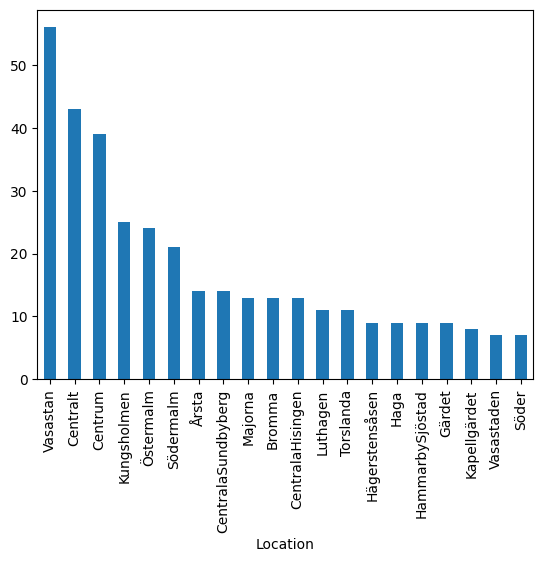

In [36]:
df["Location"].value_counts()[0:20].plot(kind = "bar")


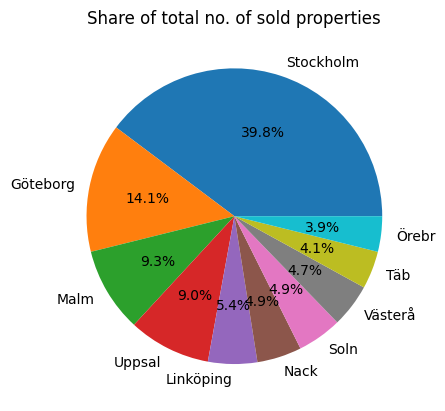

<Axes: xlabel='House_type'>

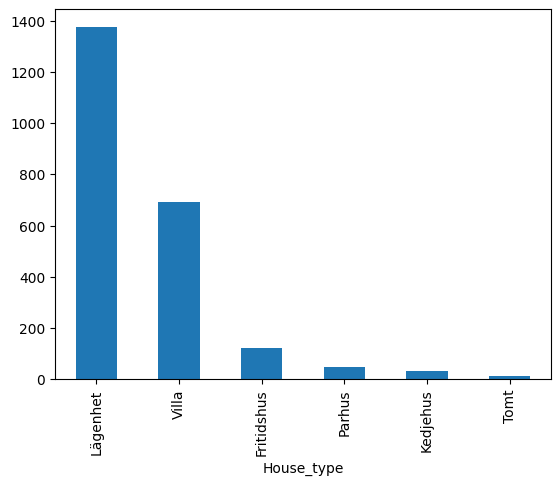

In [37]:
plt.pie(df["Municipality"].value_counts()[0:10], labels=df["Municipality"].value_counts()[0:10].index, autopct='%1.1f%%')
plt.title('Share of total no. of sold properties')

plt.show()

df["House_type"].value_counts().plot(kind="bar")

Majority of the properties sold are located in Stockholm, Götebory, Malmo and Uppsala which makes sense since these are the biggest cities in Sweden. 

Addiitonaly, most the commonly sold house type was "Lägenhet"(Appartments) and "Villa"(Villas) which also makes sense since majority of housings are generally Appartments or Villas.

Rooms, Balcony, Floor, Total_no_Floors and Lift attributes are only connected to the Appartment type and since most of the data points are for Appartments, it makes sense to keep these attributes. I do forsee some bias in the model to working better for Appartment type since we have more data points and more attributes connected to it. 

Now, lets understand more about the predictor variable i.e "Final_Price"

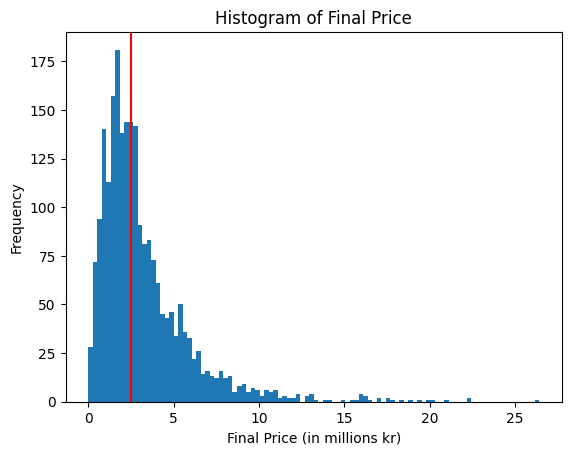

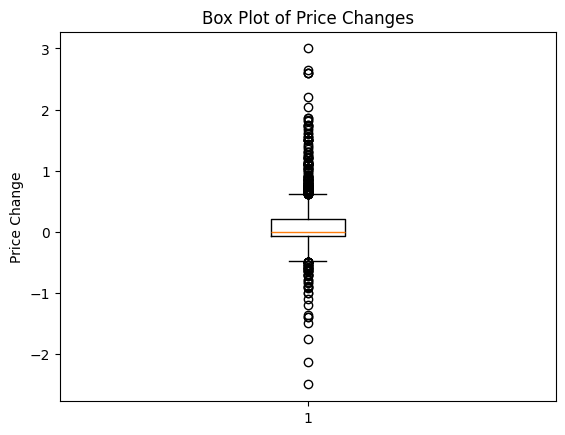

In [38]:
plt.hist(df["Final_Price"],bins = 100)
plt.xlabel('Final Price (in millions kr)')
plt.ylabel('Frequency')
plt.title('Histogram of Final Price')
plt.axvline(statistics.median(df["Final_Price"]),color = 'r')
plt.show()

plt.boxplot(df["Price_Change"])
plt.ylabel('Price Change')
plt.title('Box Plot of Price Changes')
plt.show()

From the box plot, we can see the difference between the asking and final price is generally around zero so most of the time, what is asked for is what it is gernally sold around for. But the final price can differ by + or - 1 million Kr. 

We can see that it is highly skewed to the right. The median price is 2.49 as shown above. But the price can be seen to go to a maximum of 26 million Kr. So we should explore what attributes directly impact the final price. 

Lets now see the relation of the "Final_Price" with the attributes

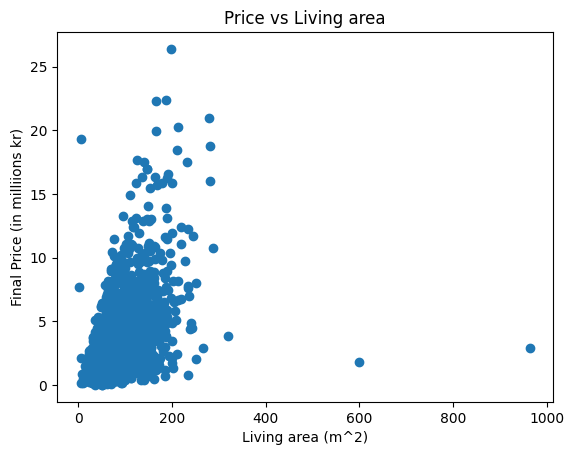

In [39]:
plt.scatter(x = df["Living_area"], y = df["Final_Price"])
plt.xlabel('Living area (m^2)')
plt.ylabel('Final Price (in milliions kr)')
plt.title('Price vs Living area')
plt.show()

There appears to be a positive correlation between the living area and the final price. Larger living areas generally correspond to higher prices, although this relationship is not perfectly linear. There is a high density of data points for properties with living areas below 200 square meters and prices ranging from 0 to 15 million kr. This indicates that most properties fall within this range. 

For living areas above 200 square meters, the final price does not increase as significantly as it does for smaller areas. Prices seem to saturate or increase at a slower rate beyond this point but we also have a very small dataset so we cannnot make this strong conclusion. 

Seeing that there is a wide range of prices, it suggests that factors other than just living area are significantly influencing the final price.

When exploring the plot area and other area, it appaears to be scattered so can't find any relationship with the price from the graph. So during the model creation phase, we can test the performance change with and without these 2 attributes. 

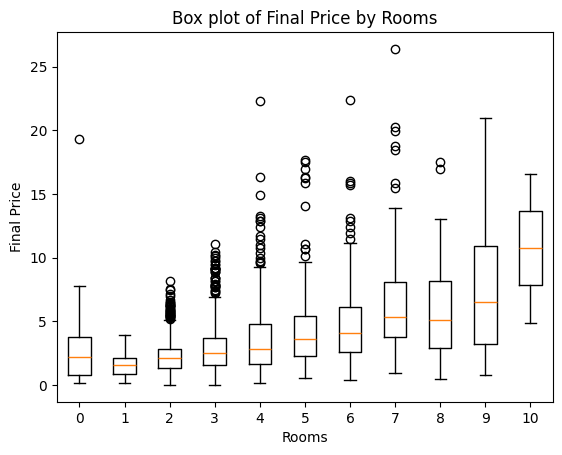

In [40]:
rooms = sorted(df["Rooms"].unique()) 
data = [df[df["Rooms"] == room]["Final_Price"] for room in rooms]

plt.boxplot(data, labels=rooms) 
plt.xlabel('Rooms') 
plt.ylabel('Final Price') 
plt.title('Box plot of Final Price by Rooms')
plt.show()

As we can see the price increases with the number of rooms which is intutive and the data supports it. 

Upon analysis of "Floor", we see that it doesnt have an impact on the price, if the property is located at a higher floor. The same is true for "Total_no_Floors". So during the model creation phase, we can test the performance change with and without these 2 attributes as well. 

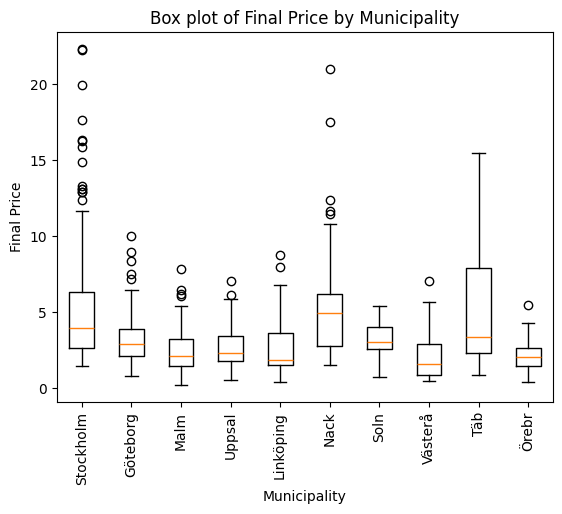

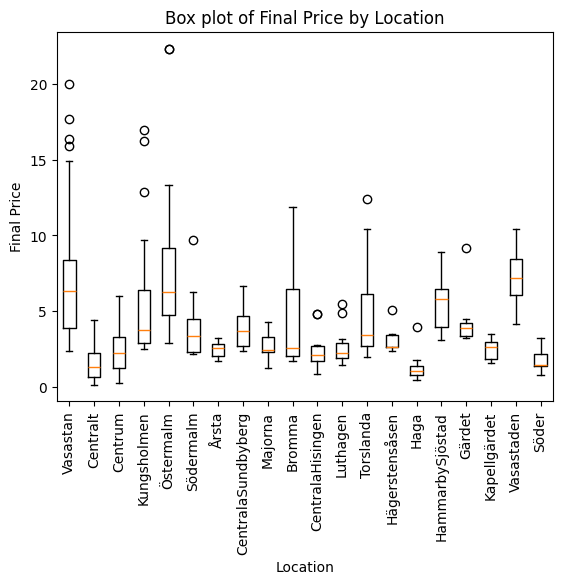

In [41]:
ms = df["Municipality"].value_counts()[0:10].index
data = [df[df["Municipality"] == m]["Final_Price"] for m in ms]

plt.boxplot(data, labels=ms)
plt.xlabel('Municipality')
plt.ylabel('Final Price')
plt.title('Box plot of Final Price by Municipality')
plt.xticks(rotation=90)
plt.show()

ls = df["Location"].value_counts()[0:20].index
data = [df[df["Location"] == l]["Final_Price"] for l in ls]

plt.boxplot(data, labels=ls)
plt.xlabel('Location')
plt.ylabel('Final Price')
plt.title('Box plot of Final Price by Location')
plt.xticks(rotation=90)
plt.show()

We can see that the final price is impacted by where the property is located implying that some areas are more valuable than others.

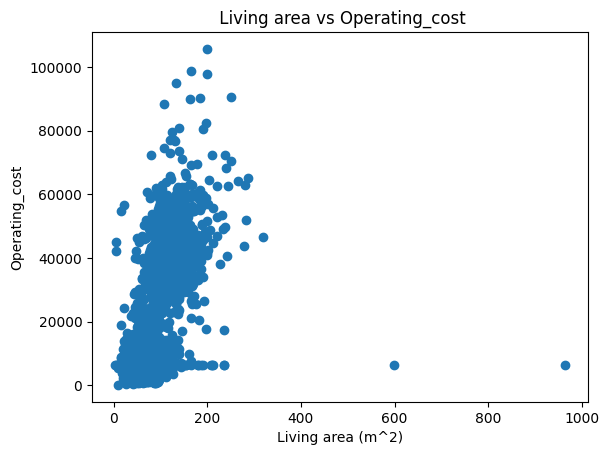

In [42]:
plt.scatter(x=df["Living_area"], y=df["Operating_cost"])
plt.xlabel('Living area (m^2)')
plt.ylabel('Operating_cost')
plt.title(' Living area vs Operating_cost')
plt.show()

There is a positive correlation between living area and Operating cost, so it makes sense to maybe not include the operating cost in the model since its information can be captured through the "Living_area" attribute. The same was seen for the "Charge" attribute. 

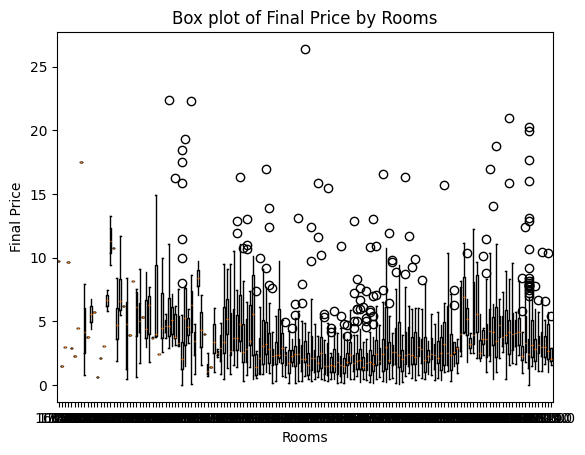

In [43]:
rooms = sorted(df["Built_on"].unique())
data = [df[df["Built_on"] == room]["Final_Price"] for room in rooms]

plt.boxplot(data, labels=rooms)
plt.xlabel('Built_on')
plt.ylabel('Final Price')
plt.title('Box plot of Final Price by Rooms')
plt.show()

We have properties that were built from 1660 to 2024. It would be better to create categories for this attribute. We can create 5 levels i.e "Before 1900s", "1900-1950" , "1951-2000", "2001-2010", "2011-present"  

In [44]:
df = df.reset_index(drop=True)
warnings.filterwarnings('ignore')


for i in range(df.shape[0]):
  if df["Built_on"][i] < 1900:
    df["Built_on"][i] = "Before 1900s"
  elif df["Built_on"][i] >= 1900 and df["Built_on"][i] <=1950:
    df["Built_on"][i] = "1900-1950"
  elif df["Built_on"][i] >= 1951 and df["Built_on"][i] <= 2000:
    df["Built_on"][i] = "1951-2000"
  elif df["Built_on"][i] >= 2001 and df["Built_on"][i] <= 2010:
    df["Built_on"][i] = "2001-2010"
  elif df["Built_on"][i] >= 2011 and df["Built_on"][i] <= 2030:
    df["Built_on"][i] = "2011-present"

In [45]:
df["Built_on"].value_counts()

Built_on
1951-2000       970
2011-present    610
1900-1950       517
2001-2010       125
Before 1900s     59
Name: count, dtype: int64

In [46]:
a = df[["Built_on", "Final_Price"]]

pd.reset_option('display.max_rows')

df["Built_on"]=df["Built_on"].astype("category")

a.groupby("Built_on").agg("median")

,Final_Price
Built_on,
1900-1950,2.6950
1951-2000,2.0000
2001-2010,3.9700
2011-present,2.7425
Before 1900s,5.3400


So looking at the above dataframe we can say that there is a difference in price based on when the property was built. But there doesnt seem to be a positive correlation with price as the property is newer which could be due u the varying prices based on the location of the property which we found out above. 

Just by analyzing the data, we can say with confidence that "Living_area", "Muncapality", "Rooms" and "Built_on" attributes has an impact on the final_price. For the other we shall explore if adding/removing them impacts the performace of the models that we will now create. 

In [47]:
dtype_dict_EDA = df.dtypes.apply(lambda x: x.name).to_dict()

with open('dtype_dict_EDA.json', 'w') as file:
    json.dump(dtype_dict_EDA, file)

df.to_csv("final_data_EDA.csv")

We are now saving the edits we made in this juypter notebook to the dataset to another csv file. I will now port this to another juypter notebook for model creation/selection. I am doing this to structure different sections so that its easier for others to follow through. 